In [ ]:
import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

In [ ]:
import os
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
BASE_DIR = os.path.join(ROOT_DIR, "predictor")

sys.path.append(ROOT_DIR)
sys.path.append(BASE_DIR)

for path in sys.path:
    if ROOT_DIR in path:
        print(path)
        
from predictor.methods import fetch_history, build_sequences, split, load_latest_model, evaluate_metrics, scale, preprocess

/home/mt/root/Janus
/home/mt/root/Janus/predictor


In [ ]:
def lstm_predict(currency: str, days: int=7):
    
    device = "cuda"
    model_dir = os.path.join(BASE_DIR, "models", "RateLSTM")
    model = load_latest_model(model_dir, currency, device, verbose=True)
    
    currency = currency.upper()
    df = preprocess(fetch_history(currency, 30))
    data = scale(df[['Rate']])

    seq = 48
    X, y = build_sequences(data, seq)
    X_train, y_train, X_test, y_test = split(X, y, 0.8)


    preds = scale(model.predict(X_test).cpu().numpy(), inverse=True)
    trues = scale(y_test.cpu().numpy(), inverse=True)
    dates = df.index[seq + len(X_train):]

    df_predict = pd.DataFrame({
        "Date": dates,
        "Currency": currency,
        "Rates": trues.flatten(),
        "Predicted_Rates": preds.flatten(),
        "local": time.strftime("%Y-%m-%d %H:%M:%S %Z", time.localtime())
    })
    
    # Generate future predictions
    future_steps = days * seq
    last_seq = data[-seq:].copy()
    future_scaled = []

    model.eval()
    for _ in range(future_steps):
        inp = torch.tensor(last_seq[np.newaxis, ...], dtype=torch.float32).to(device)
        with torch.no_grad():
            pred = model(inp).cpu().numpy().flatten()
        future_scaled.append(pred[0])
        last_seq = np.vstack([last_seq[1:], pred.reshape(1, 1)])

    future_scaled = np.array(future_scaled).reshape(-1, 1)
    future = scale(future_scaled, inverse=True)
    step = df.index[1] - df.index[0]
    future_dates = [df.index[-1] + (i+1)*step for i in range(future_steps)]

    df_forecast = pd.DataFrame({
        "Date": future_dates,
        "Currency": currency,
        "Predicted_Rates": future.flatten(),
        "local": time.strftime("%Y-%m-%d %H:%M:%S %Z", time.localtime())
    })


    
    evaluate_metrics(trues, preds)
    
    plt.figure(figsize=(14, 6))
    plt.plot(df_predict["Date"], df_predict["Rates"], label="Actual", linewidth=2)
    plt.plot(df_predict["Date"], df_predict["Predicted_Rates"], label="Predicted", linewidth=2)
    plt.plot(df_forecast["Date"], df_forecast["Predicted_Rates"], label="Forecast", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Exchange Rate")
    plt.title(f"{currency.upper()} Exchange Rate Prediction + {days}-Days Forecast")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return df_forecast

In [ ]:
fetch_history('aud', 30)

,Date,Currency,Rate,Locals
0,2025-05-19 22:14:55,AUD,467.50,2025-05-20 00:00:12 ACST
1,2025-05-19 22:56:19,AUD,468.08,2025-05-20 01:00:57 ACST
2,2025-05-19 23:55:31,AUD,468.22,2025-05-20 01:30:05 ACST
3,2025-05-20 00:00:05,AUD,468.22,2025-05-20 02:30:19 ACST
4,2025-05-20 01:10:44,AUD,467.93,2025-05-20 03:30:07 ACST
...,...,...,...,...
687,2025-06-18 16:24:44,AUD,468.94,2025-06-18 18:00:17 ACST
688,2025-06-18 16:52:15,AUD,469.16,2025-06-18 19:30:19 ACST
689,2025-06-18 18:08:24,AUD,469.37,2025-06-18 20:00:09 ACST
690,2025-06-18 18:36:20,AUD,469.12,2025-06-18 20:30:10 ACST


In [ ]:
lstm_predict('aud')

🔍 Loading latest JPY model: /home/mt/root/Janus/predictor/models/RateLSTM/RateLSTM_JPY_202506.pth
MAE  : 0.00221524
MSE  : 0.00001039
RMSE : 0.00322296
MAPE : 0.04%


,Date,Currency,Predicted_Rates,local
0,2025-06-17 16:00:00,JPY,4.989336,2025-06-17 17:59:26 ACST
1,2025-06-17 16:30:00,JPY,4.988415,2025-06-17 17:59:26 ACST
2,2025-06-17 17:00:00,JPY,4.987892,2025-06-17 17:59:26 ACST
3,2025-06-17 17:30:00,JPY,4.987555,2025-06-17 17:59:26 ACST
4,2025-06-17 18:00:00,JPY,4.987150,2025-06-17 17:59:26 ACST
...,...,...,...,...
331,2025-06-24 13:30:00,JPY,4.984371,2025-06-17 17:59:26 ACST
332,2025-06-24 14:00:00,JPY,4.984371,2025-06-17 17:59:26 ACST
333,2025-06-24 14:30:00,JPY,4.984371,2025-06-17 17:59:26 ACST
334,2025-06-24 15:00:00,JPY,4.984371,2025-06-17 17:59:26 ACST


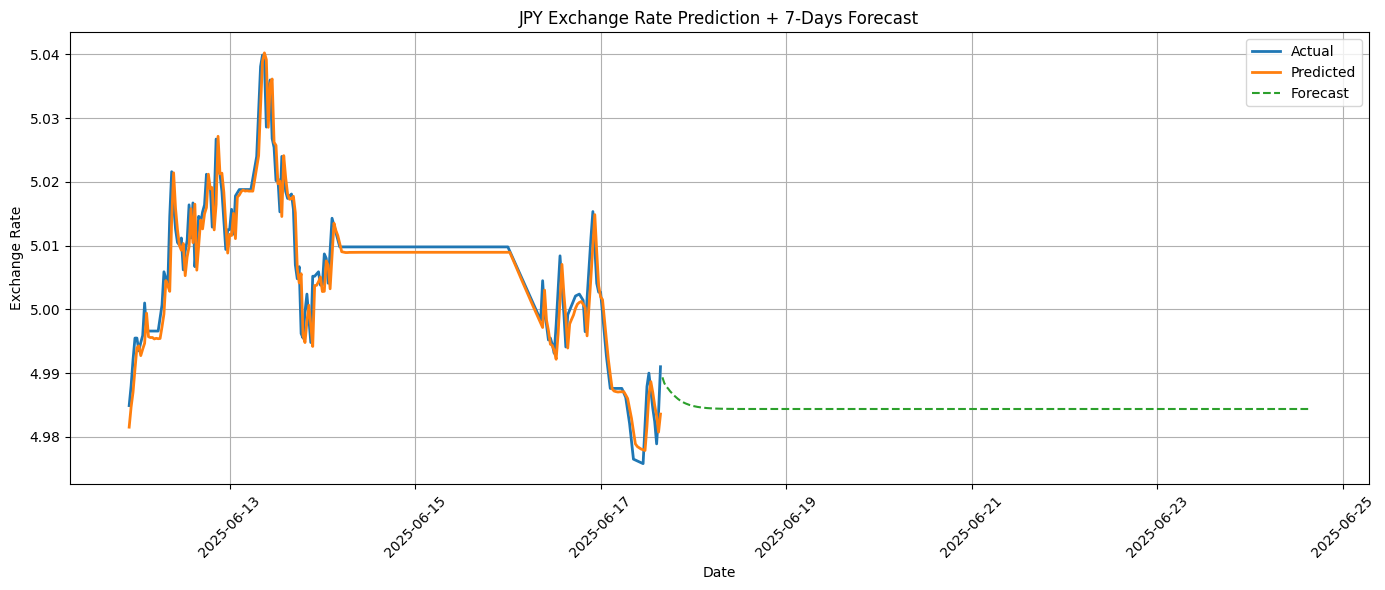

In [ ]:
lstm_predict('jpy')